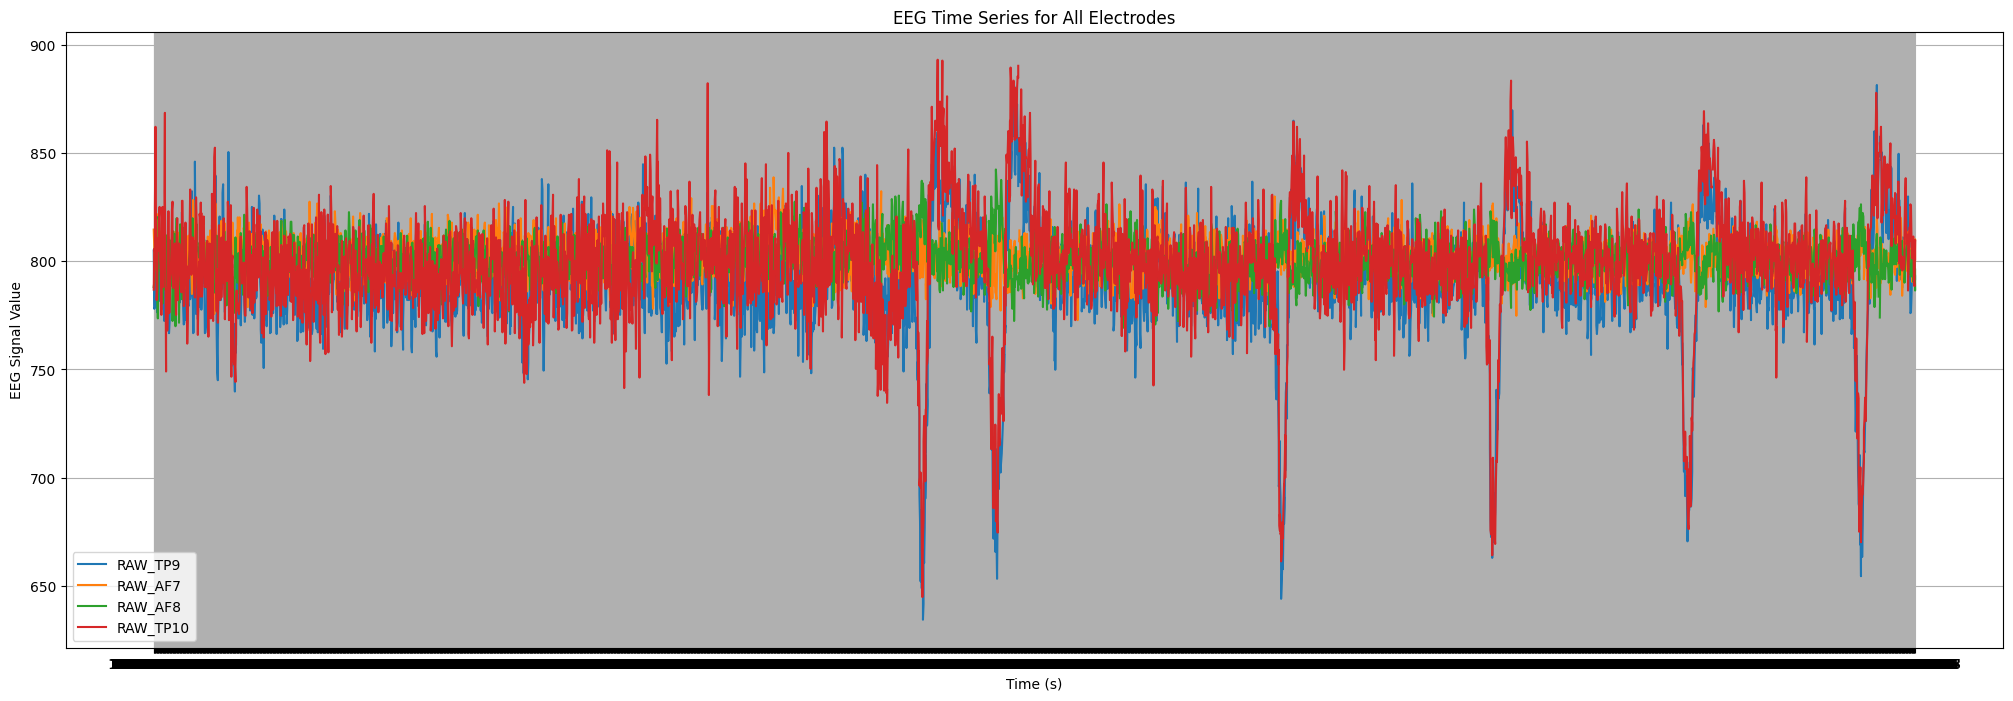

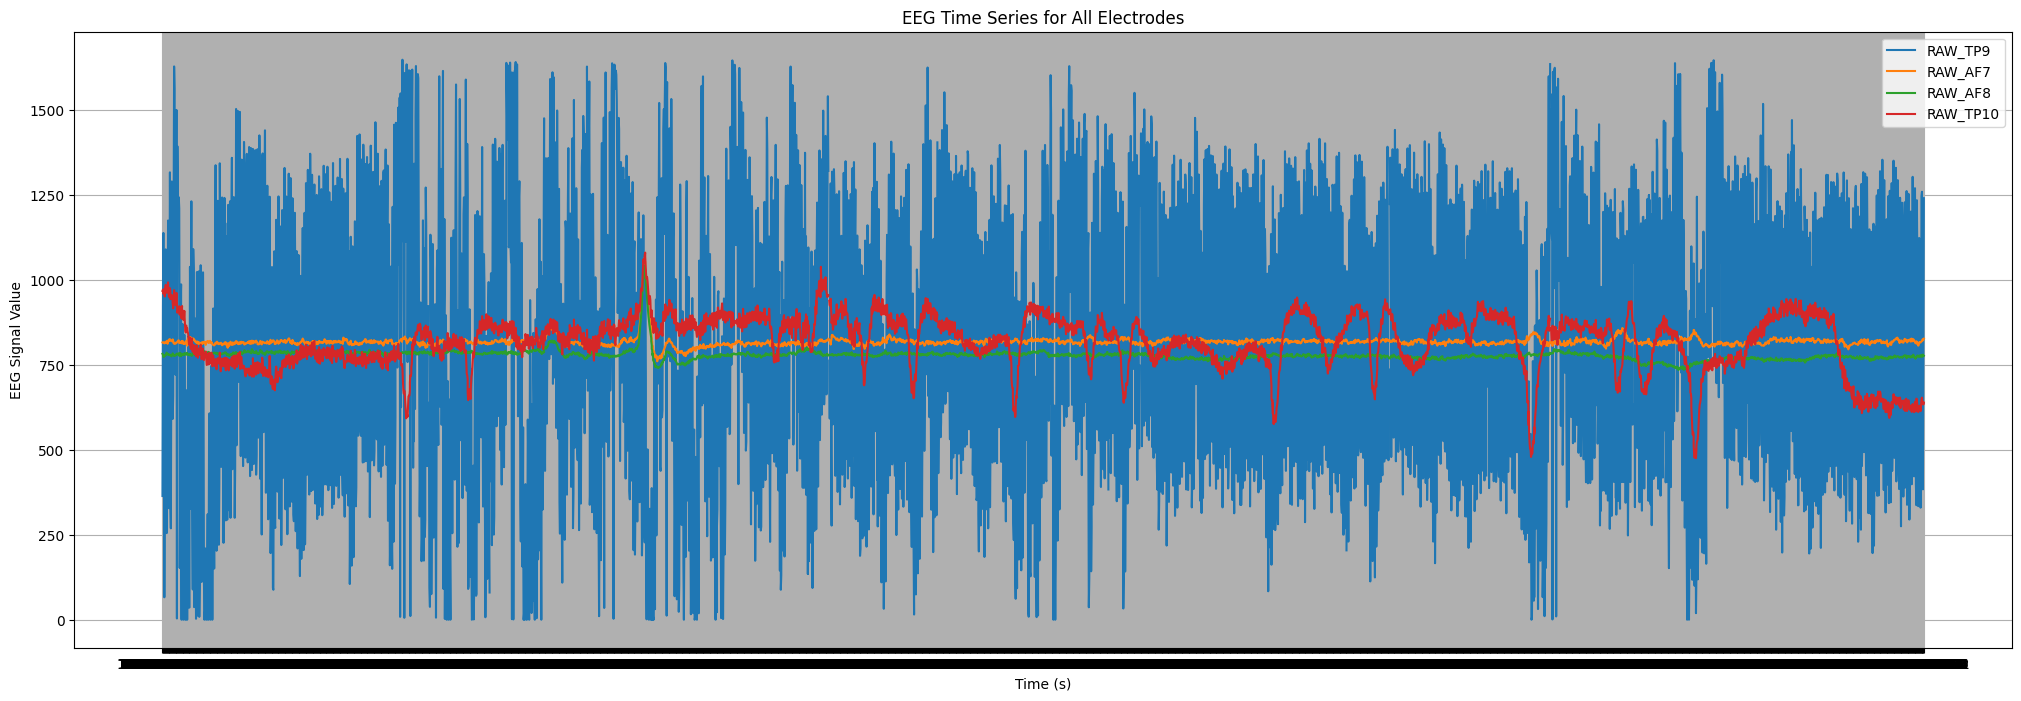

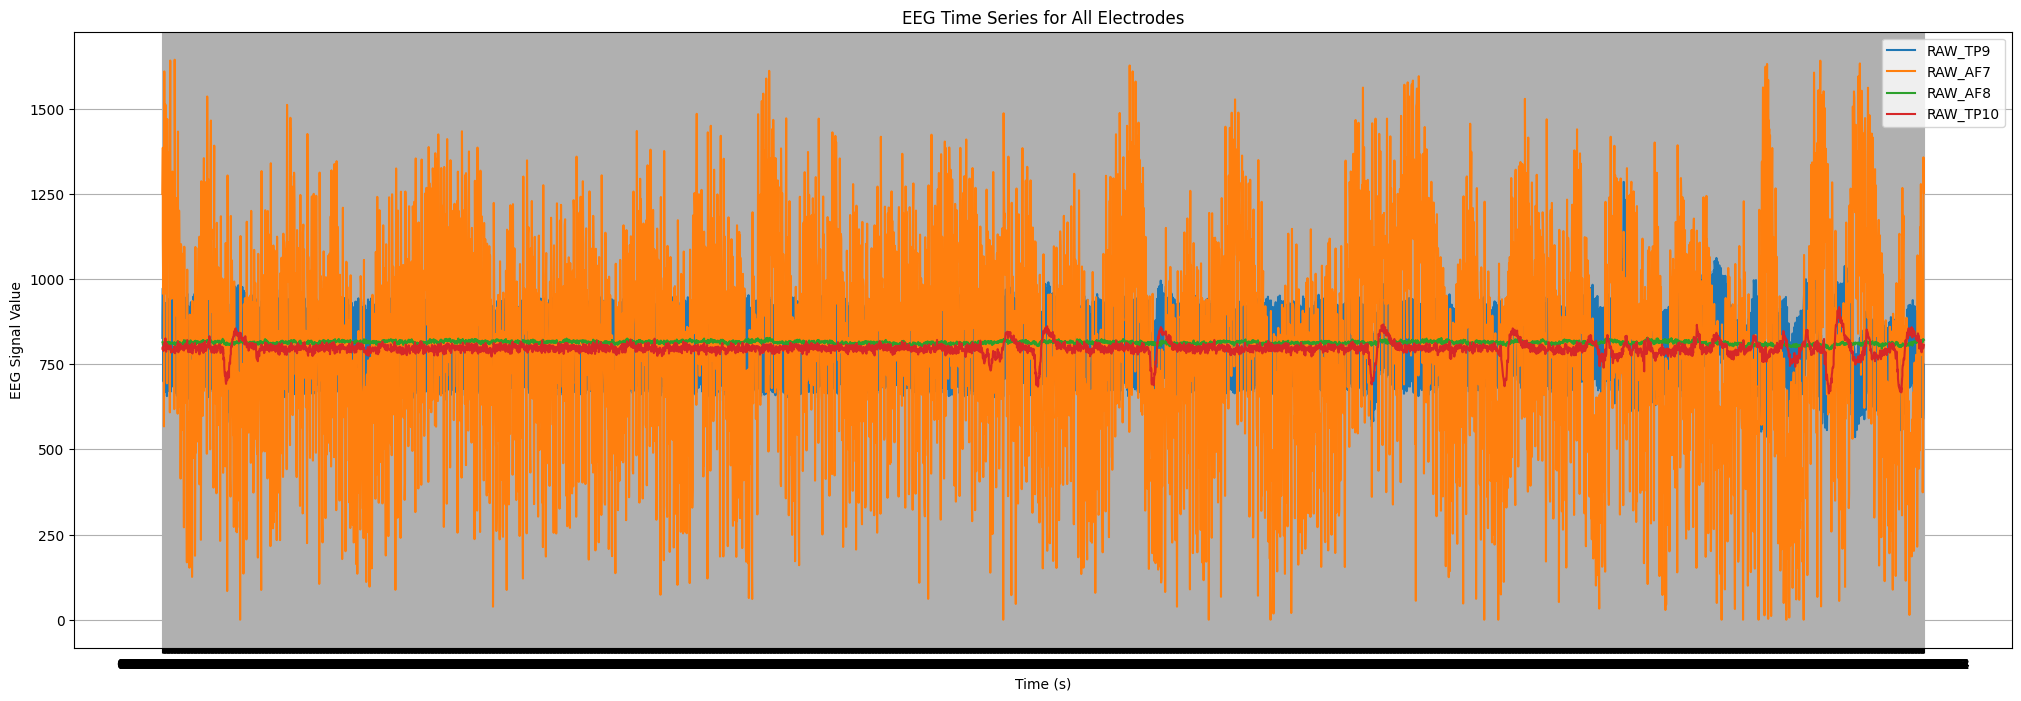

Error in callback <function flush_figures at 0x7f093cdf37e0> (for post_execute), with arguments args (),kwargs {}:


KeyboardInterrupt: 

In [19]:
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
import os

FILE_TO_PLOT = Path("./ufal_emmt/preprocessed-data/eeg/See/P03-01-S092-U-R.csv")
IMAGE_DIR = Path("./plots")

if not os.path.isdir(IMAGE_DIR):
    os.mkdir(IMAGE_DIR)

# Load CSV file
def plot_eeg_timeseries(csv_file, cols: tuple[str] | str | tuple[int, int] | int ,
                        *, show=False, out_file: Path | None=None):
    # Read the CSV
    df = pd.read_csv(csv_file)
    
    # Extract time series
    time = df['TimeStamp']
    
    if isinstance(cols, tuple):
        if isinstance(cols[0], int):
            eeg_columns = df.columns[range(*cols)]
        else:
            eeg_columns = df.columns[*cols]
    else:
        eeg_columns = df.columns[cols]
    
    # Plot each electrode signal
    plt.figure(figsize=(25, 8))
    for col in eeg_columns:
        plt.plot(time, df[col], label=col)
    
    plt.xlabel("Time (s)")
    plt.ylabel("EEG Signal Value")
    plt.title("EEG Time Series for All Electrodes")
    plt.legend()
    plt.grid()
    if show:
        plt.show()
        
    if out_file is not None:
        format = out_file.name.split(".")[-1]
        plt.savefig(out_file, format=format);


for _, file in zip(range(15), Path("./ufal_emmt/preprocessed-data/eeg/Read").glob("*.csv")):
    out_file_name = file.name[:-3] + "png"
    out_file_dir = IMAGE_DIR.joinpath(file.parts[-2])
    
    if not out_file_dir.exists():
        os.mkdir(out_file_dir)
        
    out_file = out_file_dir.joinpath(out_file_name)
    plot_eeg_timeseries(file, (21, 25), out_file=out_file)


# MNE

In [ ]:
import pandas as pd
import numpy as np
import mne

def load_eeg_to_mne(csv_file):
    # Read the CSV file
    df = pd.read_csv(csv_file)
    
    # Convert TimeStamp from HH:MM:SS.sss format to seconds
    df['TimeStamp'] = pd.to_datetime(df['TimeStamp'], format='%H:%M:%S.%f', errors='coerce')
    df['TimeStamp'] = (df['TimeStamp'] - df['TimeStamp'].iloc[0]).dt.total_seconds()
    
    # Forward-fill missing data
    df.fillna(method='ffill', inplace=True)
    
    # Ensure no NaN values remain by filling any remaining ones with 0
    df.fillna(0, inplace=True)
    time = df['TimeStamp'].values
    
    # Select EEG columns (Delta to RAW)
    eeg_columns = df.columns[21:25]  # Delta_TP9 to RAW_TP10
    eeg_data = df[eeg_columns].values.T  # Transpose to match (channels, samples)
    
    # Define sampling frequency (estimate based on time diffs)
    sfreq = 1 / np.mean(np.diff(time)) if len(time) > 1 else 256  # Default to 256 if only one timestamp
    
    # Create MNE info structure
    ch_names = list(eeg_columns)
    ch_types = ['eeg'] * len(ch_names)
    info = mne.create_info(ch_names=ch_names, sfreq=sfreq, ch_types=ch_types)
    
    # Create RawArray object
    raw = mne.io.RawArray(eeg_data, info)
    return raw

# Example usage
csv_file = FILE_TO_PLOT  # Change to the actual file path
raw = load_eeg_to_mne(csv_file)
raw.plot(scalings="auto");  # Visualize the EEG data


/tmp/ipykernel_6880/2364523468.py:14: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='ffill', inplace=True)


TypeError: create_info() missing 1 required positional argument: 'sfreq'